# credit Doug Hart: https://github.com/dougtheeconomist

## If you weren't here last time, make sure the necessary installations are made
If you were you can skip down to and run the cell containing the connection string for the database instance

In [ ]:
!pip install pymssql

#### For Mac users:
You will need to install the following program in the terminal or the notebook will throw an error when importing pymssql.

       brew install freetds

Non Mac users may not need this install at all, but in the event that they do, an ubuntu version can be found here:
    https://packages.ubuntu.com/search?keywords=FreeTDS

## Run this cell to connect to the database and set up to make queries

In [1]:
import pymssql
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../../')

with open('../../src/pw2') as pw_file:
    server, user, pw, database = pw_file.readline().split(',')
    
conn = pymssql.connect(host=server,user=user,password=pw,database=database)
cur = conn.cursor()

## Answering questions:

Once everyone is ready we'll dive into the following questions. The table schemas can be found at the bottom of this notebook, however you may find it easier to pull up the github readme for the project, which also contains these schema tables as an apendix at the end, in another window, link below:

https://github.com/dougtheeconomist/flag-on-the-play/blob/master/README.md

#### This time the primary goal is to do a little bit of data exploration in regards to penalties and coaching. 

## Task A
To warm up, perform a simple query on the guest.team table to return the names and average penalties per season of the 10 coaches with the highest average penalties per season for the teams that they coached. 

In [2]:
def pretty_query(cur, query):
    """
    Function to Pandas-prettify for Pythonic SQL Server queries
    *NOTE* It is recommended to alias any aggregate calculation columns
           because pymssql doesn't seem to auto generate one (returns an empty string).
    """
    cur.execute(query)
    data = cur.fetchall()
    headers = [col[0] for col in cur.description]
    out = pd.DataFrame(data=data, columns=headers)
    return out

In [3]:
query = """

SELECT TOP 10 AVG(against_count), coach_name
 FROM guest.teams
 GROUP BY coach_name
 ORDER BY AVG(against_count) DESC

;
"""
pretty_query(cur, query)

,,coach_name
0,134,Dan Campbell
1,132,Tom Cable
2,122,Freddie Kitchens
3,121,Adam Gase
4,121,Kliff Kingsbury
5,120,Hue Jackson
6,120,Pete Carroll
7,119,Doug Marrone
8,119,Jeff Fisher
9,119,Jon Gruden


<details><summary>
Possible solution:
</summary>

SELECT TOP 10 AVG(against_count), coach_name
    
FROM guest.teams
    
GROUP BY coach_name
    
ORDER BY AVG(against_count) DESC
    ;

## Task B
### Part 1
Now that we've seen which coaches manage teams with the highest penalties, we want to get a sense of the overall distribution of average coached penalties per season, and we want to do this visually. First write a query that returns the average penalties per season for all coaches and save the output of this query to a list or array.

In [4]:
query = """

SELECT AVG(against_count)
 FROM guest.teams
 GROUP BY coach_name

;
"""
avg_penalties = pretty_query(cur, query)

<details><summary>
Possible solution:
</summary>
conn.rollback()s
    
query = """
    
SELECT AVG(against_count)
    
FROM guest.teams
    
GROUP BY coach_name  

    ;"""

cur.execute(query)
    
list_for_graphing = cur.fetchall() 

### Part 2
Now that you have your list of averages, we want to graph these as a histogram to get a sense of ovarall distribution. However, if we print the results of this query we will see that each item returned is a tuple rather than an individual value, and Python will not graph that well. So we need to isolate the first element from each of these tuples and only graph these (the second element is empty but Python wants to graph that in a really unhelpful way).

Is it normally distributed?

array([[<AxesSubplot:>]], dtype=object)

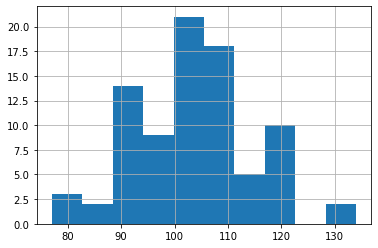

In [5]:
# Use your favorite graphing library to generate your histogram here
avg_penalties.hist()

<details><summary>
Possible solution:
</summary>
for i in range(len(list_for_graphing)):
    
    list_for_graphing[i] = list_for_graphing[i][0]

plt.hist(list_for_graphing)

## Task C
Another measurement that might be useful to look at is the variation around the average number of penalties across coaches. Repeat both parts of task B for standard deviation instead of the mean for coaches who have coached for more than 4 seasons.

In [6]:
query = """

SELECT STDEV(against_count)
 FROM guest.teams
 GROUP BY coach_name

;
"""
std_penalties = pretty_query(cur, query)

<details><summary>
Possible solution:
</summary>
conn.rollback()s
    
query = """
    
SELECT STDEV(against_count)
    
FROM guest.teams

GROUP BY coach_name
    
HAVING COUNT(year) > 4

    ;"""

cur.execute(query)
    
list_for_graphing = cur.fetchall() 
  
for i in range(len(list_for_graphing)):
    
    list_for_graphing[i] = list_for_graphing[i][0]

array([[<AxesSubplot:>]], dtype=object)

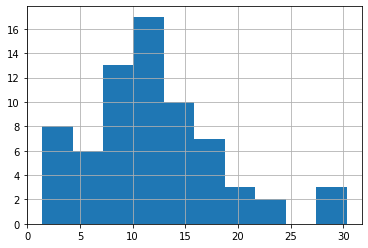

In [7]:
# Use your favorite graphing library to generate your histogram here
std_penalties.hist()

## Task D
### Part 1
There clearly is an outlier when it comes to standard deviations by coach. Write a query to identify which coach this is. 

In [8]:
query = """

SELECT TOP 1 STDEV(against_count), coach_name
 FROM guest.teams
 GROUP BY coach_name
 ORDER BY STDEV(against_count) DESC

;
"""
pretty_query(cur, query)

,,coach_name
0,30.300872,Jack Del Rio


<details><summary>
Possible solution:
</summary>
WITH coaches(name, deviation) AS 
    
(SELECT DISTINCT coach_name AS name, STDEV(against_count) AS deviation
    
FROM guest.teams
    
GROUP BY coach_name
    
HAVING COUNT(year)>4)
    

SELECT deviation, name
    
FROM coaches
    
WHERE deviation = (SELECT MAX(deviation) FROM coaches)

    ;

### Part 2
Now that you've identified *which* coach has this abnormal discrepancy in penalties per season, let's take a closer look and see why this is the case. Write a query to return the year, number of penalties and city for which the team he coaches plays for each year that he coaches. 

In [9]:
query = """
SELECT year, against_count, team_city
 FROM guest.teams
 WHERE coach_name='Jack Del Rio'
 ORDER BY year

;
"""
pretty_query(cur, query)

,year,against_count,team_city
0,2009,69,Jacksonville
1,2010,83,Jacksonville
2,2011,77,Jacksonville
3,2012,101,Jacksonville
4,2015,138,Oakland
5,2016,147,Oakland
6,2017,114,Oakland


<details><summary>
Possible solution:
</summary>
SELECT against_count, year, team_city
    
FROM guest.teams

WHERE coach_name = 'Jack Del Rio'

    ;

## Task E
Putting coaching aside, let's take a final look at the Seahawks in particular; we know from previous explorations that they are the 5th highest penalized team since the 2009 season. Write a query to return the year and percentage of total penalties accrued around the league each year that were committed by Seattle. You can output the results as a percentage using SQL Server's built in FORMAT() function. For example:

    SELECT FORMAT((37.0/38.0),'P') AS [Percentage] -- 97.37 %
    
Or to specify a different number of significant figures, include an integer after the 'P'

    SELECT FORMAT((37.0/38.0),'P0') AS [WholeNumberPercentage] -- 97 %
    SELECT FORMAT((37.0/38.0),'P3') AS [ThreeDecimalsPercentage] -- 97.368 %

(Hint: since the numerical columns found within the relevant tables are integers and SQL will return a query result in the same data type as the column in question, it will be helpful to convert the relevant numbers to a float format, which can be done with SQL's CAST() function)

In [29]:
query = """
SELECT a.year, FORMAT((s.total_flags/a.total_flags), 'P') AS p
  FROM (SELECT year, 
               CAST(SUM(against_count) AS float) AS total_flags 
          FROM guest.teams 
        GROUP BY year) a
  JOIN (SELECT year, 
               CAST(SUM(against_count) AS float) AS total_flags
          FROM guest.teams
         WHERE team_city='Seattle'
         GROUP BY year) s ON a.year=s.year
;
"""
pretty_query(cur, query)

,year,p
0,2009,3.14 %
1,2010,3.26 %
2,2011,4.17 %
3,2012,3.43 %
4,2013,4.09 %
5,2014,3.84 %
6,2015,3.30 %
7,2016,3.41 %
8,2017,4.33 %
9,2018,3.22 %


<details><summary>
Possible solution:
</summary>
WITH SUMMARY(y, total) AS (SELECT year AS y, CAST(SUM(against_count) AS float) AS total FROM guest.teams GROUP BY 
    
    year)

SELECT a.year, FORMAT((a.ac_hawks / b.total),'P') AS [Percentage] 
    
FROM (SELECT year, (CAST(against_count AS float)) AS ac_hawks FROM guest.teams WHERE team_city = 'Seattle') a 
    
JOIN SUMMARY b 
    
ON a.year = b.y


    ;

# guest.teams Table Schema

|id 			   | Description                                | Type      |
|------------------|:-------------------------------------------|:----------|
| year      	   | Year of football season                    | INT       |
| team_city 	   | City where team is located                 | VARCHAR   |
| team_id   	   | id number unique to team                   | INT       |
| coach_name       | Name of team coach                         | VARCHAR   |
| coach_id         | id number unique to coach                  | INT       |
| ranking          | Rank of most to least penalized            | INT       |
| games     	   | Games played that season                   | INT       |
| plays            | Number of plays that season                | INT       |
| against_count    | Number of flags against team               | INT       |
| agnst_yrds       | Total yards penalized in season            | INT       |
| ben_count        | Number of flags on opposing team           | INT       |
| ben_yrds     	   | Yards given for opposing flags             | INT       |
| net_count        | Team flags less opposing flags	            | INT       |
| net_yrds         | Yards lost plus yards gained from penalties| INT       |
| total_flags      | Total flags thrown in team's games         | INT       |


